In [11]:
from scipy.io import mmread
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# 1. Load the matrix
matrix = mmread("matrix.mtx").tocsc()  # Use .tocsc() or .tocsr() for efficient slicing

# 2. Load genes or features
# Try both 'genes.tsv' or 'features.tsv' depending on your version of Cell Ranger
try:
    genes = pd.read_csv("genes.tsv", header=None, sep="\t")
except FileNotFoundError:
    genes = pd.read_csv("features.tsv", header=None, sep="\t")

# 3. Load barcodes
barcodes = pd.read_csv("barcodes.tsv", header=None)

# 4. Rename for convenience
gene_names = genes.iloc[:, 1].values  # Column 1 = gene names
cell_barcodes = barcodes.iloc[:, 0].values  # Column 0 = barcode strings

# 5. Convert sparse matrix to dense (if manageable) and create DataFrame
# WARNING: Dense conversion is memory-intensive; only do this if matrix is small enough
df = pd.DataFrame.sparse.from_spmatrix(matrix.T, index=cell_barcodes, columns=gene_names)


# Optional: convert to dense DataFrame (memory intensive)
# df_dense = df.sparse.to_dense()

# Show the shape and head
print(f"Shape: {df.shape}")  # (num_cells, num_genes)
print(df.head())


Shape: (3463, 11187)
                          Mrpl15  Lypla1  Tcea1  Atp6v1h  Rb1cc1  \
DVFL2_AAACCTGAGGACCACA-1       8       1      4        1       1   
DVFL2_AAACCTGCAAAGTCAA-1       2       1      0        0       0   
DVFL2_AAACCTGCAATCAGAA-1       2       1      1        1       0   
DVFL2_AAACCTGCACTTGGAT-1       5       1      4        0       0   
DVFL2_AAACCTGCAGTATAAG-1       1       1      0        2       0   

                          4732440D04Rik  Pcmtd1  Rrs1  Vcpip1  Sgk3  ...  \
DVFL2_AAACCTGAGGACCACA-1              0       1     2       0     1  ...   
DVFL2_AAACCTGCAAAGTCAA-1              0       0     2       1     2  ...   
DVFL2_AAACCTGCAATCAGAA-1              0       1     7       1     0  ...   
DVFL2_AAACCTGCACTTGGAT-1              0       1     6       0     1  ...   
DVFL2_AAACCTGCAGTATAAG-1              0       0     0       0     0  ...   

                          mt-Co3  mt-Nd3  mt-Nd4l  mt-Nd4  mt-Nd5  mt-Nd6  \
DVFL2_AAACCTGAGGACCACA-1     120    

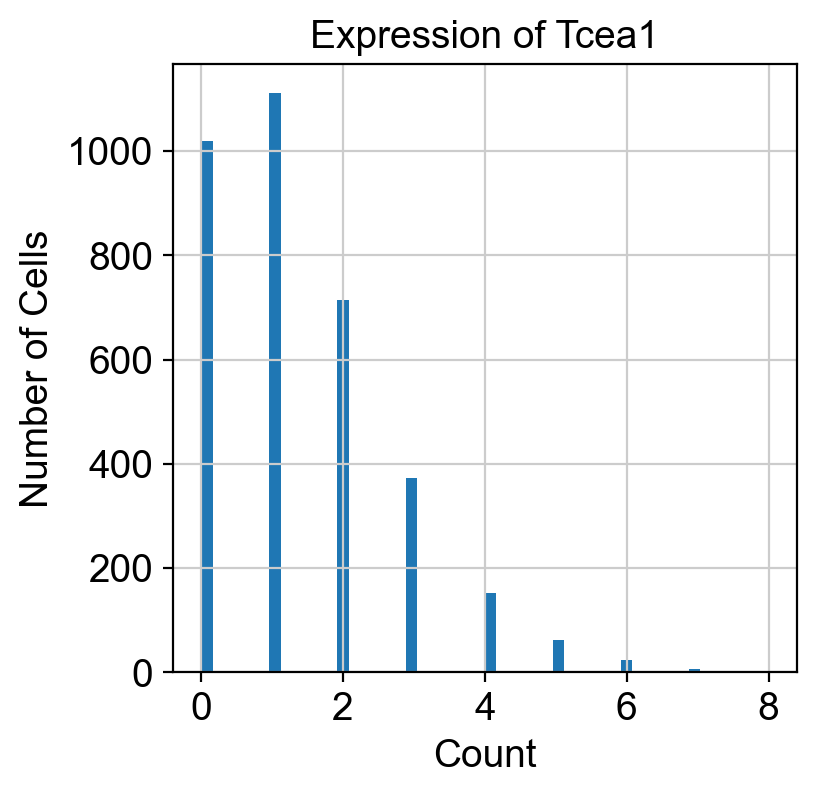

In [12]:
import matplotlib.pyplot as plt

gene = "Tcea1"  # Replace with a gene in your dataset

if gene in df.columns:
    plt.hist(df[gene].astype(float), bins=50)
    plt.title(f"Expression of {gene}")
    plt.xlabel("Count")
    plt.ylabel("Number of Cells")
    plt.show()
else:
    print(f"Gene {gene} not found in dataset.")

In [13]:
from scipy.io import mmread
import numpy as np

# Load sparse matrix
mtx = mmread("matrix.mtx")

# Convert to dense NumPy array if small
dense_mtx = mtx.toarray()

# View first few rows
print(dense_mtx)

[[8 2 2 ... 5 5 0]
 [1 1 1 ... 3 3 0]
 [4 0 1 ... 0 3 2]
 ...
 [1 2 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [2 0 1 ... 0 0 0]]


✅ Loaded data: (2730, 3451) (cells, genes)


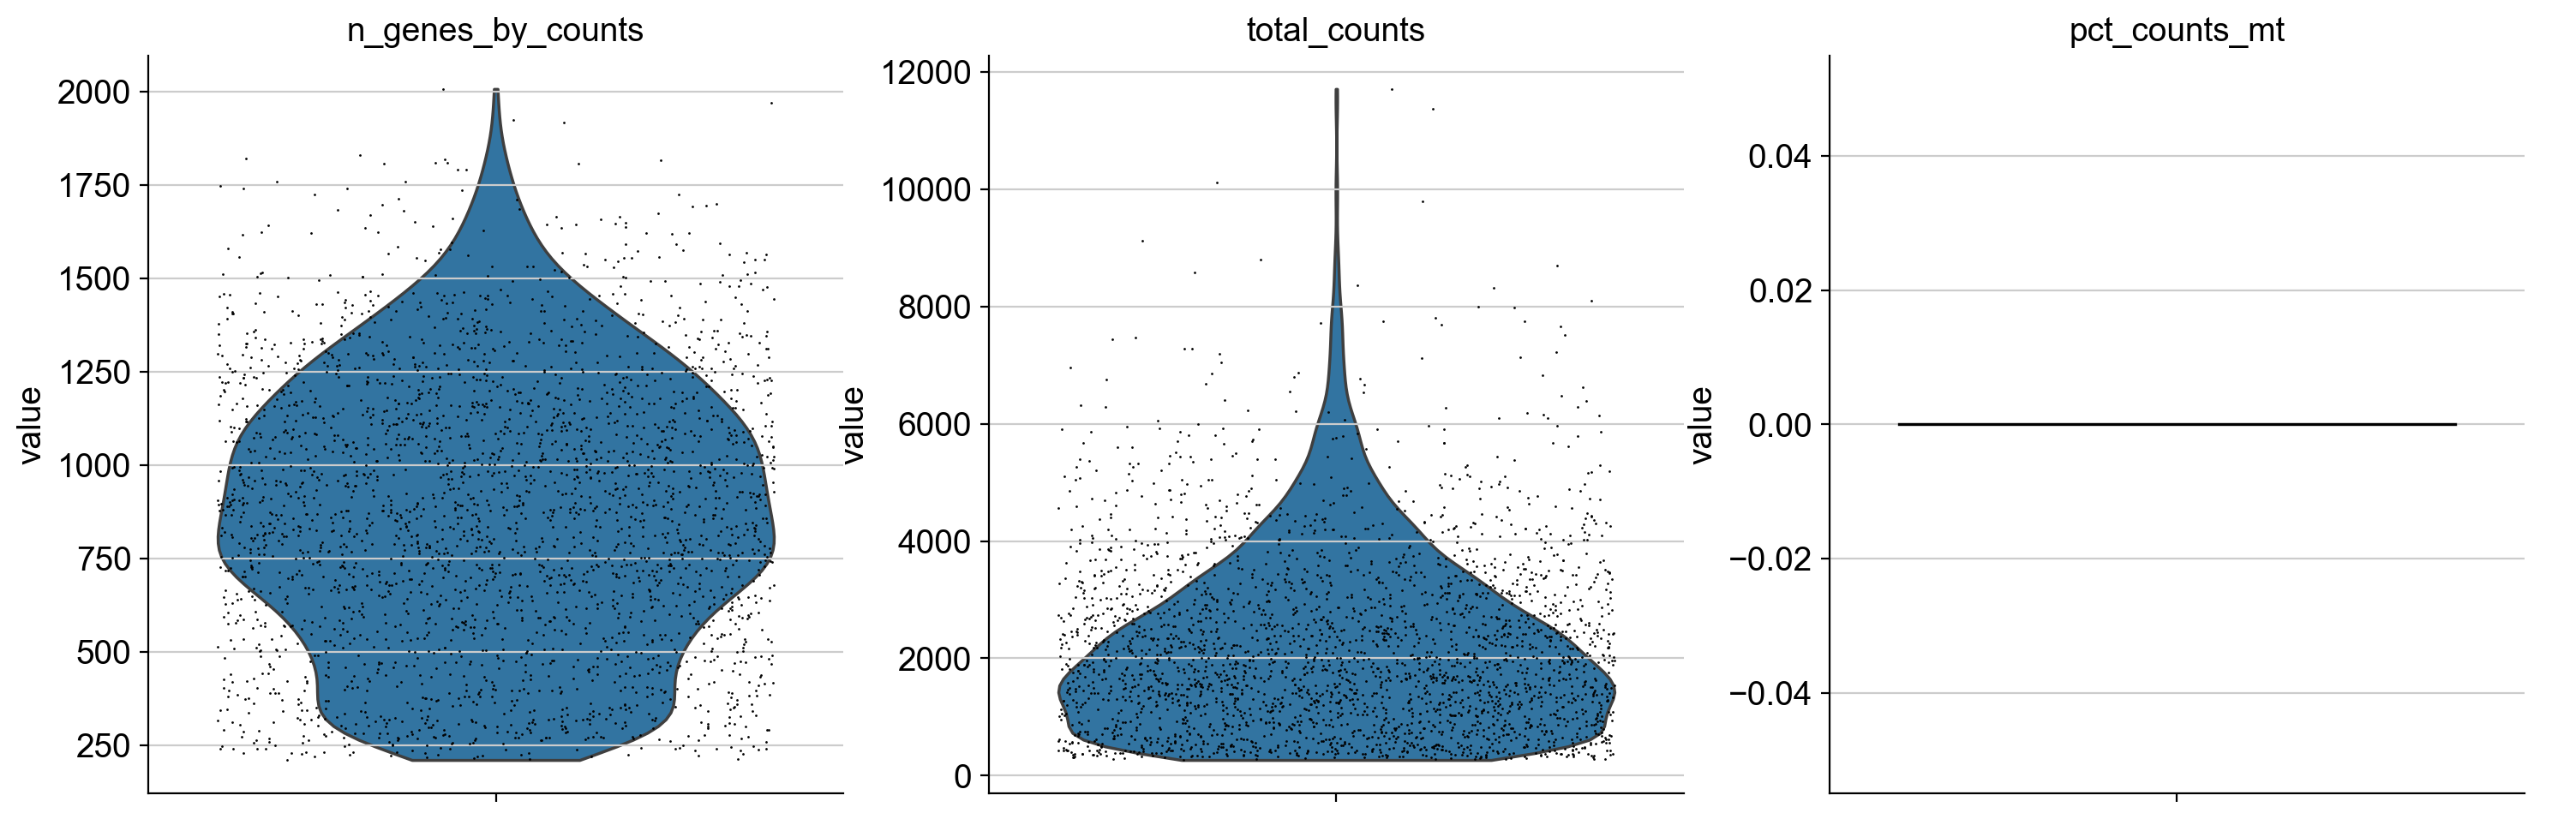

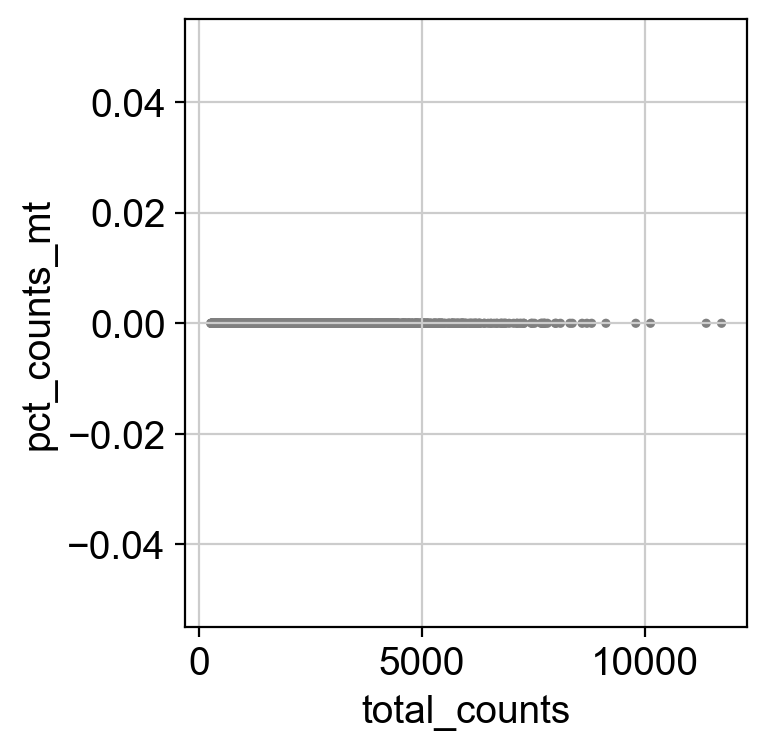

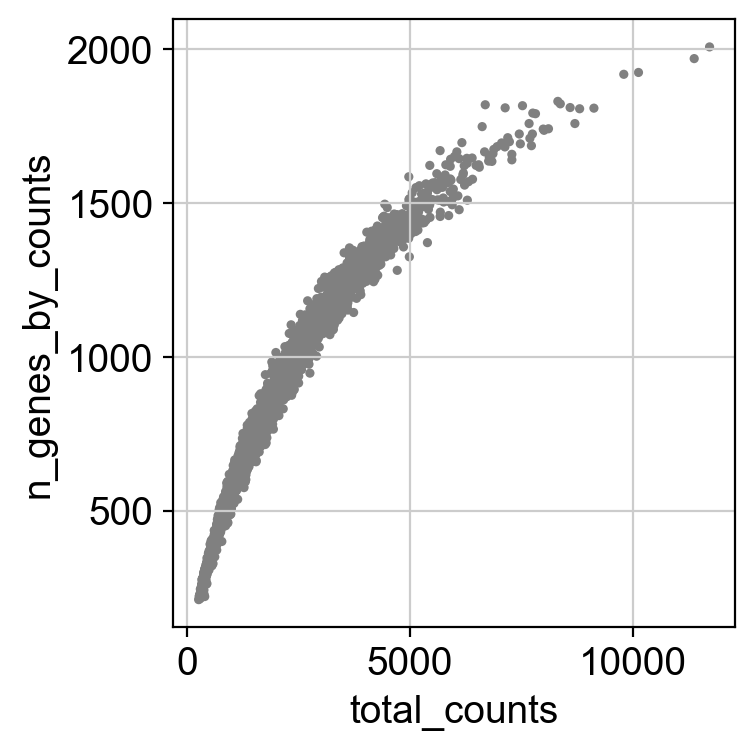

🔎 Before filtering: (2730, 3267)
✅ After filtering: (2589, 3267)


/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


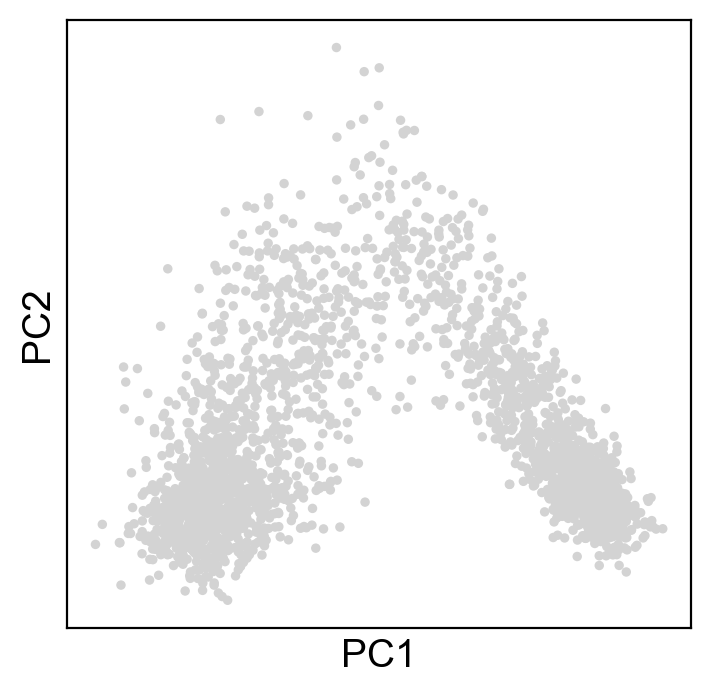

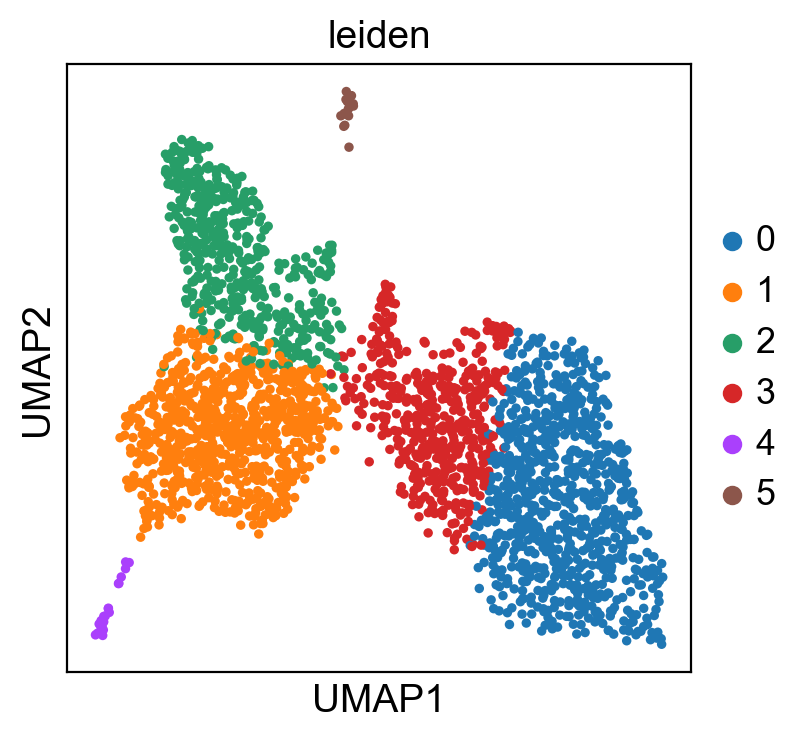

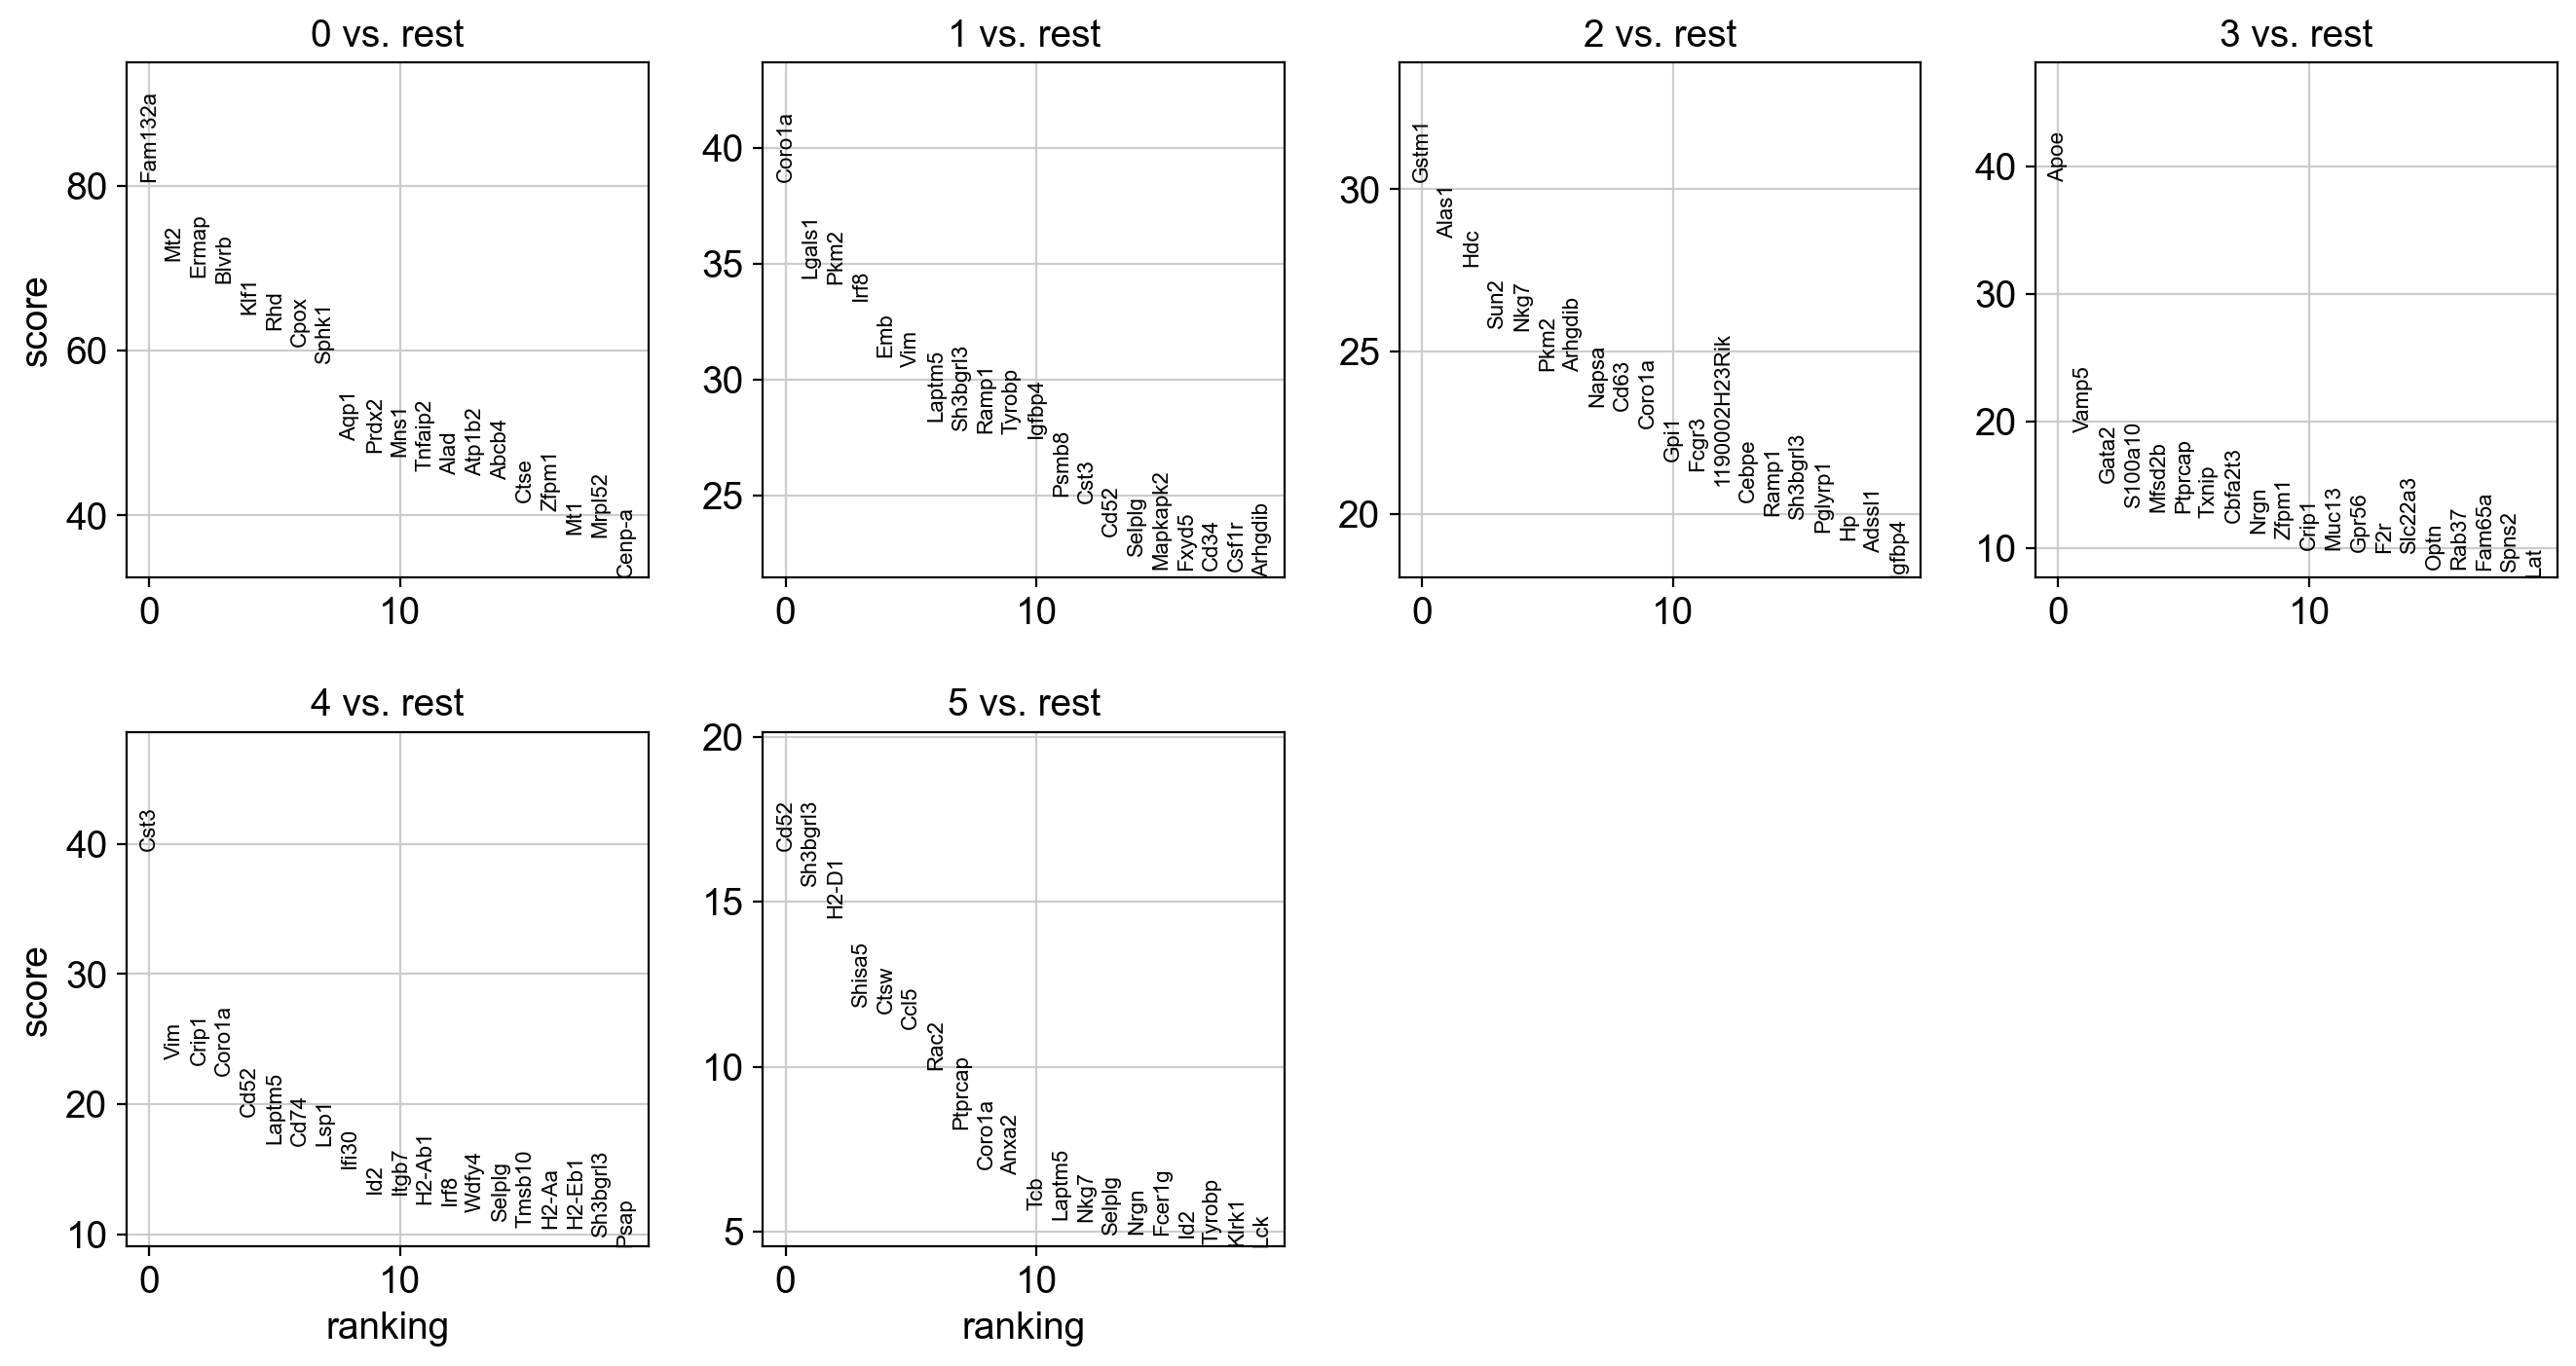

saving figure to file figures/umap_clusters.png


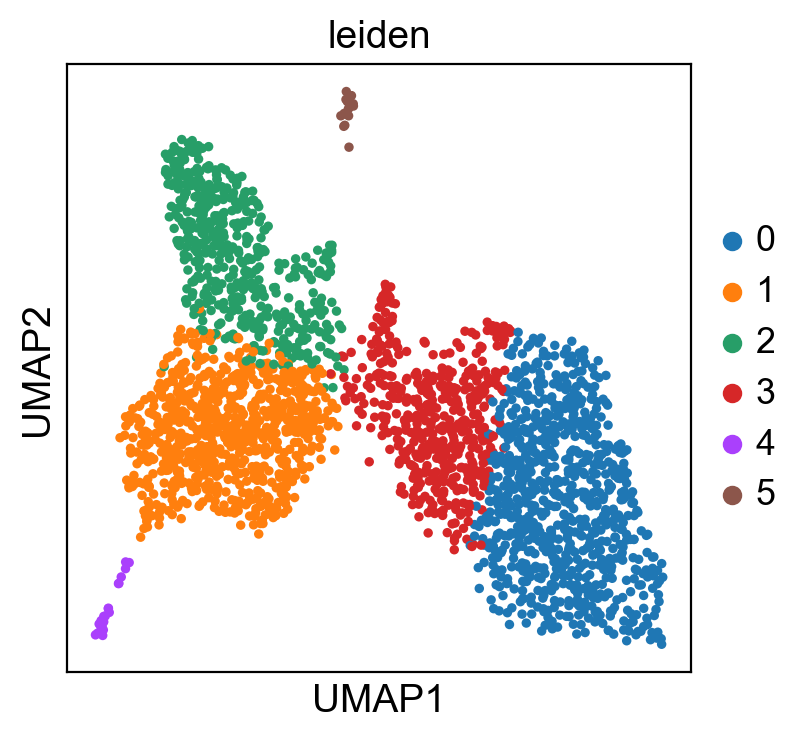

✅ Pipeline complete!
 - processed_data.h5ad
 - marker_genes.csv
 - UMAP plot saved


In [14]:
# 📦 Imports
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────
# 🔧 Scanpy Settings
# ──────────────────────────────────────────────
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100, facecolor='white')

# ──────────────────────────────────────────────
# 📁 Load Data
# ──────────────────────────────────────────────
# Example dataset — replace with your actual 10x directory
# data_dir = "path/to/10x_data"
# adata = sc.read_10x_mtx(data_dir, var_names='gene_symbols', cache=True)

adata = sc.datasets.paul15()  # REMOVE this line when using real data
print(f"✅ Loaded data: {adata.shape} (cells, genes)")

# ──────────────────────────────────────────────
# 🧼 Step 1: Basic QC
# ──────────────────────────────────────────────
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=30)

# Annotate mitochondrial genes
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# Visualize QC metrics
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True
)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

# ──────────────────────────────────────────────
# 🧼 Step 2: Filtering
# ──────────────────────────────────────────────
print("🔎 Before filtering:", adata.shape)

# Adjust thresholds as needed
adata = adata[(adata.obs.n_genes_by_counts < 6000) &
              (adata.obs.n_genes_by_counts > 300) &
              (adata.obs.pct_counts_mt < 20), :]

print("✅ After filtering:", adata.shape)

if adata.n_obs == 0:
    raise ValueError("❌ All cells removed during filtering — adjust thresholds.")

# ──────────────────────────────────────────────
# 🧪 Step 3: Normalize & Log-transform
# ──────────────────────────────────────────────
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# ──────────────────────────────────────────────
# 🔍 Step 4: Highly Variable Genes
# ──────────────────────────────────────────────
sc.pp.highly_variable_genes(
    adata,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5
)
adata = adata[:, adata.var.highly_variable]

# ──────────────────────────────────────────────
# 🔬 Step 5: Scale & PCA
# ──────────────────────────────────────────────
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)

# ──────────────────────────────────────────────
# 🤝 Step 6: Neighbors & UMAP
# ──────────────────────────────────────────────
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

# ──────────────────────────────────────────────
# 🔖 Step 7: Clustering
# ──────────────────────────────────────────────
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'])

# ──────────────────────────────────────────────
# 🧬 Step 8: Marker Gene Discovery
# ──────────────────────────────────────────────
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

marker_df = sc.get.rank_genes_groups_df(adata, group=None)
marker_df.to_csv("marker_genes.csv", index=False)

# ──────────────────────────────────────────────
# 💾 Step 9: Save Results
# ──────────────────────────────────────────────
adata.write("processed_data.h5ad")
sc.pl.umap(adata, color=['leiden'], save="_clusters.png")

print("✅ Pipeline complete!")
print(" - processed_data.h5ad")
print(" - marker_genes.csv")
print(" - UMAP plot saved")


In [5]:
# Step 1: Build graph (Scanpy or custom)
# Step 2: Train GNN to embed state
# Step 3: Create Gym-style environment for cell fate transitions
# Step 4: Train RL agent with GNN-based policy


#scRNA-seq data → Gene Expression Matrix → GRN Inference (SCENIC / GRNBoost)
#         ↓
#    Graph: Genes = nodes, regulation = edges
#         ↓
#    GNN → encodes current cell state from GRN
#         ↓
#RL Agent (PPO, A2C, etc.)
 #        ↓
# Selects action (TF activation, perturbation)
  #       ↓
#Environment simulates cell transition → Next GRN-encoded state


In [26]:
import scanpy as sc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from scipy.sparse import issparse
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ----------------- Repro seeds & device -----------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("cpu")  # CPU for multiprocess pickling; change if single-GPU

# ----------------- Config / Hyperparams -----------------
N_GENES_SELECT = 20
GCN_HIDDEN = 64
GCN_EMB = 32
AE_TRAIN_EPOCHS = 100
ACTION_MAGNITUDE = 0.25
MAX_STEPS = 10

# ----------------- Adaptive Threshold Class -----------------
class PerGeneAdaptiveThreshold:
    def __init__(self, gene_list, alpha=0.1):
        self.thresholds = {int(g): 0.0 for g in gene_list}
        self.alpha = alpha
    def update(self, gene_rewards):
        for gene_id, reward in gene_rewards.items():
            if reward is None or (isinstance(reward, float) and np.isnan(reward)):
                continue
            gid = int(gene_id)
            prev = self.thresholds.get(gid, 0.0)
            self.thresholds[gid] = self.alpha * float(reward) + (1 - self.alpha) * prev
    def get(self, gene_id):
        return float(self.thresholds.get(int(gene_id), 0.0))

# ----------------- Step 1: Load & preprocess data -----------------
adata = sc.read_10x_mtx("Untitled Folder 3/")
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, inplace=True)
adata = adata[:, adata.var.highly_variable]
sc.tl.pca(adata)

# ----------------- Step 2: Pseudotime inference -----------------
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.diffmap(adata)
adata.uns['iroot'] = 0
sc.tl.dpt(adata)
pseudotime = adata.obs['dpt_pseudotime'].values

# ----------------- Step 3: Gene selection -----------------
X_full = adata.X.toarray() if issparse(adata.X) else np.asarray(adata.X)
y = pseudotime
mi_scores = mutual_info_regression(X_full, y, discrete_features=False, random_state=SEED)
N = min(N_GENES_SELECT, X_full.shape[1])
top_gene_indices = np.argsort(mi_scores)[-N:]
X = X_full[:, top_gene_indices].astype(np.float32)
adata = adata[:, top_gene_indices]
selected_gene_names = list(adata.var_names)

# ----------------- Step 4: Train/test split and normalization -----------------
n_cells, n_genes = X.shape
indices = np.arange(n_cells)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=SEED, shuffle=True)
expression_train = X[train_idx]
expression_test = X[test_idx]
pseudotime_train = pseudotime[train_idx]
pseudotime_test = pseudotime[test_idx]
gene_means = expression_train.mean(axis=0)
gene_stds = expression_train.std(axis=0) + 1e-8
expression_train = (expression_train - gene_means) / gene_stds
expression_test = (expression_test - gene_means) / gene_stds
X = np.vstack([expression_train, expression_test])

# ----------------- Step 5: Adjacency matrix -----------------
X_full_selected = X_full[:, top_gene_indices]
peak_pt = np.zeros(n_genes, dtype=float)
order = np.argsort(pseudotime)
for g in range(n_genes):
    vals = X_full_selected[order, g]
    peak_idx = int(np.nanargmax(vals))
    peak_pt[g] = pseudotime[order][peak_idx]
corr_matrix = np.corrcoef(np.vstack([expression_train, expression_test]).T)
adj_matrix = np.zeros_like(corr_matrix)
corr_threshold = 0.1
for i in range(n_genes):
    for j in range(n_genes):
        if i == j:
            continue
        if peak_pt[i] < peak_pt[j] and abs(corr_matrix[i, j]) >= corr_threshold:
            adj_matrix[i, j] = float(corr_matrix[i, j])
adj_tensor = torch.tensor(adj_matrix, dtype=torch.float32)
edge_index, edge_weight = dense_to_sparse(adj_tensor)
edge_index = edge_index.long().cpu()
edge_weight = edge_weight.float().cpu()

# ----------------- Step 6: GCN Autoencoder -----------------
class GCN_AE(nn.Module):
    def __init__(self, in_dim=1, hidden_dim=GCN_HIDDEN, emb_dim=GCN_EMB):
        super().__init__()
        self.enc1 = GCNConv(in_dim, hidden_dim)
        self.enc2 = GCNConv(hidden_dim, emb_dim)
        self.dec = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_dim)
        )
    def forward(self, x, edge_index):
        x = self.enc1(x, edge_index)
        x = F.relu(x)
        emb = self.enc2(x, edge_index)
        recon = self.dec(emb)
        return recon, emb

mean_expr = np.mean(expression_train, axis=0).reshape(-1, 1).astype(np.float32)
x_input = torch.tensor(mean_expr)
gcn_ae = GCN_AE(in_dim=1).to(DEVICE)
opt = torch.optim.Adam(gcn_ae.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()
gcn_ae.train()
print("\n--- Pretraining GCN-AE ---")
for epoch in range(AE_TRAIN_EPOCHS):
    opt.zero_grad()
    recon, emb = gcn_ae(x_input.to(DEVICE), edge_index.to(DEVICE))
    loss = loss_fn(recon.squeeze(), x_input.squeeze())
    loss.backward()
    opt.step()
    if (epoch + 1) % 50 == 0:
        print(f"AE epoch {epoch+1}/{AE_TRAIN_EPOCHS} loss {loss.item():.6f}")
torch.save(gcn_ae.state_dict(), "gcn_ae.pth")
gcn_ae.eval()

# ----------------- Step 7: GCN Encoder -----------------
class GeneGCN_Encoder(nn.Module):
    def __init__(self, gcn_ae):
        super().__init__()
        self.enc1 = gcn_ae.enc1
        self.enc2 = gcn_ae.enc2
    def forward(self, x, edge_index):
        x = self.enc1(x, edge_index)
        x = F.relu(x)
        emb = self.enc2(x, edge_index)
        return emb

encoder = GeneGCN_Encoder(gcn_ae).to(DEVICE)
encoder.eval()
torch.save(encoder.state_dict(), "gcn_encoder.pth")

# ----------------- Step 8: Discrete CRISPR GRN Environment -----------------
class GRNEnvModelFreeCRISPR(gym.Env):
    """Discrete gene environment with CRISPR perturbations."""
    metadata = {"render_modes": ["human"]}

    def __init__(self, expression, pseudotime, max_steps=MAX_STEPS, adaptive_thresholds=None,
                 device='cpu', action_magnitude=ACTION_MAGNITUDE, perturb_prob=0.1, max_perturb=3):
        super().__init__()
        self.expression = np.asarray(expression, dtype=np.float32)
        self.pseudotime = np.asarray(pseudotime, dtype=np.float32)
        self.n_cells, self.n_genes = self.expression.shape
        self.max_steps = max_steps
        self.adaptive_thresholds = adaptive_thresholds
        self.device = device
        self.action_magnitude = action_magnitude
        self.perturb_prob = perturb_prob
        self.max_perturb = max_perturb

        # Discrete action: for each gene -1,0,+1
        self.action_space = spaces.Discrete(self.n_genes * 3)
        self.observation_space = spaces.Box(low=-5.0, high=5.0, shape=(self.n_genes,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.idx = np.random.randint(self.n_cells)
        self.state = self.expression[self.idx].copy()
        self.original_state = self.state.copy()

        eligible_idxs = np.where(self.pseudotime > self.pseudotime[self.idx])[0]
        if len(eligible_idxs) == 0:
            eligible_idxs = np.array([self.idx])
        target_idx = np.random.choice(eligible_idxs)
        self.target = self.expression[target_idx].copy()

        self.reward_gene = int(np.random.randint(self.n_genes))
        self.target_value = float(self.target[self.reward_gene])

        self.steps = 0
        self.history = [self.state.copy()]
        self.knockout_genes = set()
        self.overexpressed_genes = set()

        # Apply CRISPR perturbation at reset
        self._apply_crispr_perturbation()
        return self.state.copy(), {}

    def _apply_crispr_perturbation(self):
        n_perturb = np.random.randint(1, self.max_perturb + 1)
        for _ in range(n_perturb):
            gene = np.random.randint(0, self.n_genes)
            if np.random.rand() < 0.5:  # knockout
                self.state[gene] = 0.0
                self.knockout_genes.add(gene)
            else:  # overexpression
                self.state[gene] *= 2.0
                self.overexpressed_genes.add(gene)

    def step(self, action):
        # Convert discrete action to gene + direction
        gene_id = action // 3
        direction = (action % 3) - 1  # -1,0,+1
        self.state[gene_id] = np.clip(self.state[gene_id] + direction * self.action_magnitude, -5.0, 5.0)

        # Apply occasional CRISPR perturbation
        if np.random.rand() < self.perturb_prob:
            self._apply_crispr_perturbation()

        old_mse = float(np.mean((self.history[-1] - self.target)**2))
        new_mse = float(np.mean((self.state - self.target)**2))
        reward = old_mse - new_mse

        gene_improvement = (abs(self.original_state[self.reward_gene] - self.target[self.reward_gene])
                            - abs(self.state[self.reward_gene] - self.target[self.reward_gene]))
        reward += 0.2 * float(gene_improvement)

        if self.adaptive_thresholds:
            threshold = self.adaptive_thresholds.get(self.reward_gene)
            reward -= threshold

        self.steps += 1
        self.history.append(self.state.copy())

        terminated = self.steps >= self.max_steps
        truncated = False
        info = {"old_mse": old_mse, "new_mse": new_mse, "reward_gene": int(self.reward_gene)}

        return self.state.copy(), float(reward), terminated, truncated, info

    def render(self, mode='human'):
        print(f"Step {self.steps} - gene {self.reward_gene} value {self.state[self.reward_gene]:.4f}")
        print(f"Knockouts: {sorted(list(self.knockout_genes))}, Overexpressed: {sorted(list(self.overexpressed_genes))}")

# ----------------- Step 9: Environment & Training -----------------
gene_list = list(range(expression_train.shape[1]))
adaptive_thresholds = PerGeneAdaptiveThreshold(gene_list)

def make_env():
    return GRNEnvModelFreeCRISPR(expression_train, pseudotime_train, adaptive_thresholds)




/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca



--- Pretraining GCN-AE ---
AE epoch 50/100 loss 0.000000
AE epoch 100/100 loss 0.000000


In [20]:
# --------------------------
# Full RL Training Script: PPO Variants + Detailed Evaluation



In [28]:
# --------------------------
# Full PPO Script with Multiple Optimizers (fixed optimizer_class)
# --------------------------
import os
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, average_precision_score
)
from dtaidistance import dtw
from scipy.interpolate import interp1d

import gym
from gym import spaces
import torch
import torch.nn.functional as F

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import torch
from torch.optim import Optimizer  # <-- add this import
import torch
from torch import optim
from torch.optim import Optimizer
import math
def count_nonzero(tensor):
    return int((tensor != 0).sum().item())
# --------------------------
# CONFIGURATION
# --------------------------
SEED = 42
DEVICE = "cuda"  # "cpu" or "cuda"
MAX_STEPS = 100
PERTURB_PROB = 0.1
MAX_PERTURB = 3
n_eval_episodes=100
# --------------------------
# ENV WRAPPER
# --------------------------
class GRNEnvWrapper(gym.Env):
    def __init__(self, base_env):
        super().__init__()
        self.env = base_env
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.env.expression.shape[1],),
            dtype=np.float32
        )
        self.action_space = self.env.action_space

    def reset(self, **kwargs):
        state = self.env.reset(**kwargs)
        if isinstance(state, tuple):
            state = state[0]
        if not hasattr(self.env, 'current_cell'):
            self.env.current_cell = 0
        return np.array(state, dtype=np.float32)

    def step(self, action):
        result = self.env.step(action)
        if len(result) == 5:
            obs, reward, terminated, truncated, info = result
            done = terminated or truncated
        else:
            obs, reward, done, info = result
        obs = np.array(obs, dtype=np.float32)
        if hasattr(self.env, 'current_cell'):
            self.env.current_cell += 1
        return obs, reward, done, info

    def seed(self, seed=None):
        if hasattr(self.env, 'seed'):
            self.env.seed(seed)
        np.random.seed(seed)

# --------------------------
# UTILITY FUNCTIONS
# --------------------------
def resample_sequence(seq, target_len):
    seq = np.asarray(seq)
    orig_len = len(seq)
    if orig_len == target_len:
        return seq
    x_old = np.linspace(0, 1, orig_len)
    x_new = np.linspace(0, 1, target_len)
    f = interp1d(x_old, seq, kind='linear')
    return f(x_new)

def make_env_factory(expression, pseudotime, adaptive_thresholds,
                     perturb_prob=PERTURB_PROB, max_perturb=MAX_PERTURB):
    def _init():
        base_env = GRNEnvModelFreeCRISPR(
            expression=expression,
            pseudotime=pseudotime,
            max_steps=MAX_STEPS,
            adaptive_thresholds=adaptive_thresholds,
            device=DEVICE,
            perturb_prob=perturb_prob,
            max_perturb=max_perturb
        )
        return GRNEnvWrapper(base_env)
    return _init

# --------------------------
# MODEL EVALUATION
# --------------------------
def evaluate_model(model, env, n_eval_episodes=10):
    rewards = []
    for _ in range(n_eval_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
    return np.mean(rewards), np.std(rewards)

def train_with_retry(model, total_timesteps, retries=3):
    for attempt in range(1, retries + 1):
        try:
            model.learn(total_timesteps=total_timesteps)
            break
        except IndexError as e:
            print(f"⚠️ IndexError during training attempt {attempt}: {e}")
            if attempt == retries:
                raise
            print("Retrying training...")

# --------------------------
# ASGD / Padam / Custom Optimizers
# --------------------------
def count_nonzero(tensor):
    return int((tensor != 0).sum().item())

class ASGDAdam(Optimizer):
    """ASGD-style optimizer using separate lr_min/lr_max per step."""
    def __init__(self, params, lr=None, beta1=0.9, beta2=0.999, eps=1e-8,
                 lr_min=1e-4, lr_max=3e-4):
        defaults = dict(beta1=beta1, beta2=beta2, eps=eps, lr_min=lr_min, lr_max=lr_max)
        super().__init__(params, defaults)
        self.last_total_nonzero_fmin = 0
        self.last_total_nonzero_fmax = 0
        self.last_lr = lr_max

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        total_nonzero_fmin, total_nonzero_fmax = 0, 0
        for group in self.param_groups:
            beta1, beta2, eps = group['beta1'], group['beta2'], group['eps']
            for p in group['params']:
                if p.grad is None:
                    continue
                g = p.grad
                state = self.state[p]
                if not state:
                    state['t'] = 0
                    state['m'] = torch.zeros_like(p)
                    state['v'] = torch.zeros_like(p)
                    state['v_prev'] = torch.zeros_like(p)
                m, v = state['m'], state['v']
                state['t'] += 1
                t = state['t']
                m.mul_(beta1).add_(g, alpha=1-beta1)
                v.mul_(beta2).addcmul_(g, g, value=1-beta2)
                dv = v - state['v_prev']
                state['v_prev'].copy_(v)
                f_min = (dv > 0).to(dtype=torch.int32)
                f_max = (dv <= 0).to(dtype=torch.int32)
                total_nonzero_fmin += count_nonzero(f_min)
                total_nonzero_fmax += count_nonzero(f_max)
                mhat = m / (1 - beta1 ** t)
                state['step_dir'] = mhat / (v.sqrt().add(eps))
        use_lr_min = (total_nonzero_fmax < 2 * total_nonzero_fmin)
        self.last_total_nonzero_fmin = total_nonzero_fmin
        self.last_total_nonzero_fmax = total_nonzero_fmax
        for group in self.param_groups:
            lr = group['lr_min'] if use_lr_min else group['lr_max']
            self.last_lr = lr
            for p in group['params']:
                if p.grad is not None and 'step_dir' in self.state[p]:
                    p.add_(self.state[p]['step_dir'], alpha=-lr)
        return loss

class ASGDAmsgrad(Optimizer):
    """ASGD-style optimizer mimicking AMSGrad"""
    def __init__(self, params, lr=None, beta1=0.9, beta2=0.999, eps=1e-8,
                 lr_min=1e-5, lr_max=3e-4):
        defaults = dict(beta1=beta1, beta2=beta2, eps=eps, lr_min=lr_min, lr_max=lr_max)
        super().__init__(params, defaults)
        self.last_total_nonzero_fmin = 0
        self.last_total_nonzero_fmax = 0
        self.last_lr = lr_max

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        total_nonzero_fmin, total_nonzero_fmax = 0, 0
        for group in self.param_groups:
            beta1, beta2, eps = group['beta1'], group['beta2'], group['eps']
            for p in group['params']:
                if p.grad is None:
                    continue
                g = p.grad
                state = self.state[p]
                if not state:
                    state['t'] = 0
                    state['m'] = torch.zeros_like(p)
                    state['v'] = torch.zeros_like(p)
                    state['v_hat'] = torch.zeros_like(p)
                    state['v_prev'] = torch.zeros_like(p)
                m, v, v_hat = state['m'], state['v'], state['v_hat']
                state['t'] += 1
                t = state['t']
                m.mul_(beta1).add_(g, alpha=1-beta1)
                v.mul_(beta2).addcmul_(g, g, value=1-beta2)
                torch.maximum(v_hat, v, out=v_hat)
                denom = v_hat.sqrt().add(eps)
                dv = v - state['v_prev']
                state['v_prev'].copy_(v)
                f_min = (dv > 0).to(dtype=torch.int32)
                f_max = (dv <= 0).to(dtype=torch.int32)
                total_nonzero_fmin += count_nonzero(f_min)
                total_nonzero_fmax += count_nonzero(f_max)
                mhat = m / (1 - beta1 ** t)
                state['step_dir'] = mhat / denom
        use_lr_min = (total_nonzero_fmax < 2 * total_nonzero_fmin)
        self.last_total_nonzero_fmin = total_nonzero_fmin
        self.last_total_nonzero_fmax = total_nonzero_fmax
        for group in self.param_groups:
            lr = group['lr_min'] if use_lr_min else group['lr_max']
            self.last_lr = lr
            for p in group['params']:
                if p.grad is not None and 'step_dir' in self.state[p]:
                    p.add_(self.state[p]['step_dir'], alpha=-lr)
        return loss

class Padam(Optimizer):
    """Padam optimizer"""
    def __init__(self, params, lr=1e-3, betas=(0.9,0.999), eps=1e-8, weight_decay=0, amsgrad=False, p=0.125):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=amsgrad, p=p)
        super().__init__(params, defaults)
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Padam does not support sparse gradients')
                state = self.state[p]
                amsgrad = group['amsgrad']
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1
                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                if amsgrad:
                    torch.maximum(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                step_size = group['lr'] / bias_correction1
                denom = denom.pow(group['p'])
                if group['weight_decay'] != 0:
                    grad = grad.add(p.data, alpha=group['weight_decay'])
                p.data.addcdiv_(exp_avg, denom, value=-step_size)
        return loss


    
def evaluate_and_plot(model, algo_name, expression_test, adj_matrix, pseudotime_test,
                      gene_names, edge_index, edge_weight, encoder_path,
                      adaptive_thresholds, n_episodes=50):
    results = []
    eval_env_factory = make_env_factory(expression_test, pseudotime_test, adaptive_thresholds)

    for gene_idx, gene_name in enumerate(gene_names):
        y_true, y_pred = [], []
        perturbed_vals, original_vals, pseudotimes = [], [], []

        for ep in range(n_episodes):
            env = eval_env_factory()
            try:
                obs = env.reset()
            except IndexError:
                continue

            original = env.env.original_state.copy()
            target = env.env.target.copy()
            pt_idx = getattr(env.env, "current_cell", 0)
            pt_value = float(env.env.pseudotime[pt_idx])
            done = False
            traj_pred = []

            while not done:
                try:
                    action, _ = model.predict(obs, deterministic=True)
                    obs, reward, done, _ = env.step(action)
                except IndexError:
                    break
                traj_pred.append(env.env.state[gene_idx])

            if not traj_pred:
                continue

            final_state = env.env.history[-1]
            delta = float(final_state[gene_idx] - original[gene_idx])
            label = 1 if target[gene_idx] > original[gene_idx] else 0
            prediction = 1 if delta > 0 else 0

            y_true.append(label)
            y_pred.append(prediction)
            perturbed_vals.append(float(final_state[gene_idx]))
            original_vals.append(float(original[gene_idx]))
            pseudotimes.append(pt_value)

        if not y_true:
            continue

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
        try:
            auprc = average_precision_score(y_true, y_pred)
        except ValueError:
            auprc = np.nan
        mse = mean_squared_error(original_vals, perturbed_vals)
        corr = np.corrcoef(original_vals, perturbed_vals)[0, 1] if np.std(original_vals) != 0 else 0.0

        results.append({
            "Algorithm": algo_name,
            "Gene": gene_name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            "AUPRC": auprc,
            "Final Expression MSE": mse,
            "Final Expression Correlation": corr
        })

        # Plot per-gene pseudotime trajectory
        df = pd.DataFrame({"pseudotime": pseudotimes,
                           "original_expression": original_vals,
                           "perturbed_expression": perturbed_vals})
        df['delta'] = df['perturbed_expression'] - df['original_expression']
        df['label'] = df['delta'].apply(lambda x: "Up" if x > 0 else "Down")
        plt.figure(figsize=(8, 4))
        sns.scatterplot(data=df, x="pseudotime", y="perturbed_expression", hue="label", style="label")
        sns.lineplot(data=df.sort_values('pseudotime'), x="pseudotime", y="perturbed_expression",
                     lw=1, alpha=0.5)
        plt.title(f"{algo_name} — {gene_name} Perturbation")
        plt.xlabel("Pseudotime")
        plt.ylabel("Expression (z-score)")
        plt.grid(True)
        plt.legend()
        os.makedirs("pseudotime_plots", exist_ok=True)
        plt.savefig(f"pseudotime_plots/{algo_name}_{gene_name}.png", dpi=300)
        plt.close()

    return pd.DataFrame(results)
    
    
    
    
    
    
    
    
    
    
    

class PPOAdam(PPO):
    def __init__(self, *args, **kwargs):
        if "policy_kwargs" not in kwargs:
            kwargs["policy_kwargs"] = {}
        kwargs["policy_kwargs"].update({"optimizer_class": optim.Adam})
        super().__init__(*args, **kwargs)


class PPOSGD(PPO):
    def __init__(self, *args, **kwargs):
        if "policy_kwargs" not in kwargs:
            kwargs["policy_kwargs"] = {}
        kwargs["policy_kwargs"].update({"optimizer_class": optim.SGD})
        super().__init__(*args, **kwargs)


class PPOPadam(PPO):
    def __init__(self, *args, **kwargs):
        if "policy_kwargs" not in kwargs:
            kwargs["policy_kwargs"] = {}
        kwargs["policy_kwargs"].update({"optimizer_class": Padam})
        super().__init__(*args, **kwargs)


class PPOASGDAdam(PPO):
    def __init__(self, *args, **kwargs):
        if "policy_kwargs" not in kwargs:
            kwargs["policy_kwargs"] = {}
        kwargs["policy_kwargs"].update({
            "optimizer_class": ASGDAdam,
            "optimizer_kwargs": {"lr_min": 5e-7, "lr_max": 3e-4}
        })
        super().__init__(*args, **kwargs)


class PPOASGDAmsgrad(PPO):
    def __init__(self, *args, **kwargs):
        if "policy_kwargs" not in kwargs:
            kwargs["policy_kwargs"] = {}
        kwargs["policy_kwargs"].update({
            "optimizer_class": ASGDAmsgrad,
            "optimizer_kwargs": {"lr_min": 5e-5, "lr_max": 3e-4}
        })
        super().__init__(*args, **kwargs)


# --------------------------
# Base kwargs / optimizer mapping
# --------------------------
base_kwargs = {
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "clip_range": 0.2,
    "ent_coef": 0.0,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "policy_kwargs": dict(net_arch=[dict(pi=[128,128, 128, 64], vf=[128,128, 128, 64])],
                          activation_fn=torch.nn.Tanh)
}

optimizer_kwargs = {
    "adam": dict(learning_rate=1e-4, n_steps=2048, batch_size=64, n_epochs=200),
    "sgd": dict(learning_rate=1e-2, n_steps=2048, batch_size=64, n_epochs=200),
    "padam": dict(learning_rate=1e-2, n_steps=2048, batch_size=64, n_epochs=200),
    "asgdadam": dict(n_steps=2048, batch_size=64, n_epochs=200),
    "asgdaamsgrad": dict(n_steps=2048, batch_size=64, n_epochs=200),
}

algo_map = {
    "adam": PPOAdam,
    "sgd": PPOSGD,
    "padam": PPOPadam,
    "asgdadam": PPOASGDAdam,
    "asgdaamsgrad": PPOASGDAmsgrad,
}
train_steps=100000

# --------------------------
# Training Loop
# --------------------------
results_reward = {}
trained_models = {}
eval_env = DummyVecEnv([make_env_factory(expression_train, pseudotime_train, adaptive_thresholds)])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.)

for opt_name, PPOClass in algo_map.items():
    print(f"\n--- Training {PPOClass.__name__} ---")
    train_env = DummyVecEnv([make_env_factory(expression_train, pseudotime_train, adaptive_thresholds)])
    kwargs = base_kwargs.copy()
    kwargs.update(optimizer_kwargs[opt_name])
    model = PPOClass("MlpPolicy", train_env, verbose=0, seed=SEED, **kwargs)
    train_with_retry(model, train_steps)
    trained_models[opt_name] = model
    mean_r, std_r = evaluate_model(model, eval_env, n_eval_episodes=n_eval_episodes)
    results_reward[opt_name] = (mean_r, std_r)

df_rewards = pd.DataFrame(results_reward, index=["mean_reward", "std_reward"]).T
df_rewards.to_csv("reward_summary_optimizers.csv")
print("\nReward summary:\n", df_rewards)

# --------------------------
# Per-gene evaluation
# --------------------------
all_metrics_df = []
for algo_name, model in trained_models.items():
    print(f"\n--- Evaluating per-gene metrics for {algo_name} ---")
    metrics_df = evaluate_and_plot(
        model=model,
        algo_name=algo_name,
        expression_test=expression_test,
        adj_matrix=adj_matrix,
        pseudotime_test=pseudotime_test,
        gene_names=selected_gene_names,
        edge_index=edge_index,
        edge_weight=edge_weight,
        encoder_path="gcn_encoder.pth",
        adaptive_thresholds=adaptive_thresholds,
        n_episodes=30
    )
    all_metrics_df.append(metrics_df)

final_df = pd.concat(all_metrics_df, ignore_index=True)
final_df.to_csv("per_gene_metrics_optimizers.csv", index=False)
summary_df = final_df.groupby("Algorithm").mean(numeric_only=True)
summary_df.to_csv("overall_metrics_optimizers.csv")

print("\n✅ Training & evaluation complete for all optimizers.")



--- Training PPOAdam ---

--- Training PPOSGD ---

--- Training PPOPadam ---

--- Training PPOASGDAdam ---

--- Training PPOASGDAmsgrad ---

Reward summary:
               mean_reward  std_reward
adam            -3.919123   17.782560
sgd             -8.396785   25.207861
padam           -5.487571   17.855783
asgdadam        -6.604258   18.412598
asgdaamsgrad    -5.729111   17.840122

--- Evaluating per-gene metrics for adam ---

--- Evaluating per-gene metrics for sgd ---

--- Evaluating per-gene metrics for padam ---

--- Evaluating per-gene metrics for asgdadam ---


/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



--- Evaluating per-gene metrics for asgdaamsgrad ---

✅ Training & evaluation complete for all optimizers.
